In [30]:
from nutils import mesh, function, solver, export, cli, testing
from nutils.expression_v2 import Namespace
import treelog
import matplotlib.pyplot as plt
import numpy as np

In [90]:
def main(nelems, etype, btype, degree):

    #Unit square geometry and mesh
    domain, geom = mesh.unitsquare(nelems, etype)
    
    #Namespace
    ns = Namespace()
    ns.x = geom
    ns.define_for('x', gradient='∇', normal='n', jacobians=('dV', 'dS'))
    ns.basis = domain.basis(btype, degree=degree)
    ns.u = function.dotarg('lhs', ns.basis) #Solution
    ns.f = 2*ns.x[0]*ns.x[1] #Forcing
    ns.eta = 2*ns.x[0]*ns.x[1] #Neumann BC
    ns.g = 2 #Dirichlet BC

    #Residual
    res = domain.integral('∇_i(basis_n) ∇_i(u) dV' @ ns, degree=degree*2) #Stiffness
    res -= domain.integral('basis_n f dV' @ ns, degree=degree*2) #Forcing
    res -= domain.boundary['top'].integral('basis_n eta dS' @ ns, degree=degree*2) #Neumann BC
    res -= domain.boundary['bottom'].integral('basis_n eta dS' @ ns, degree=degree*2) #Neumann BC
    
    #Dirichlet BC
    sqr = domain.boundary['left'].integral('(u - g)^2 dS' @ ns, degree=degree*2)
    sqr += domain.boundary['right'].integral('(u - g)^2 dS' @ ns, degree=degree*2)
    cons = solver.optimize('lhs', sqr, droptol=1e-15)

    # The unconstrained entries of ``?lhs`` are to be determined such that the
    # residual vector evaluates to zero in the corresponding entries. This step
    # involves a linearization of ``res``, resulting in a jacobian matrix and
    # right hand side vector that are subsequently assembled and solved. The
    # resulting ``lhs`` array matches ``cons`` in the constrained entries.
    lhs = solver.solve_linear('lhs', res, constrain=cons)
    
    #Sampling of the solution
    bezier = domain.sample('bezier', 9)
    x, u = bezier.eval(['x_i', 'u'] @ ns, lhs=lhs)
    
    #plot
    plt.tripcolor(x[:,0], x[:,1], u)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.colorbar()

    return cons, lhs

optimize > solve > solving 22 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 6e-16
optimize > constrained 22/121 dofs
optimize > optimum value 0.00e+00
solve > solving 99 dof system to machine precision using arnoldi solver
solve > solver returned with residual 6e-15


(array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2., nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.]),
 array([2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.02078466, 2.02163887, 2.02411748, 2.02816717,
        2.03382724, 2.0412192 , 2.05052749, 2.06196842, 2.07574709,
        2.09200634, 2.11077672, 2.0398273

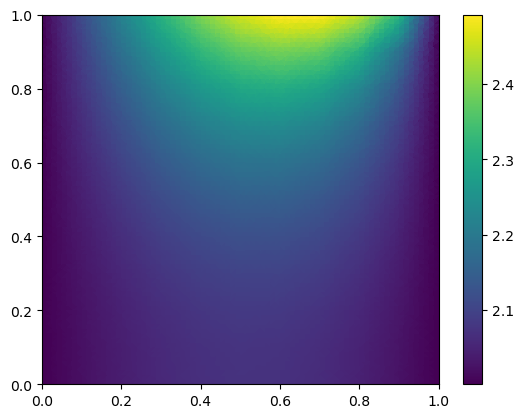

In [91]:
main(nelems=10, etype='square', btype='spline', degree=1)